In [1]:
#import gdown
#url = "https://docs.google.com/uc?export=download&id=1xT8E9RJOv1gLFtmkJuI4e-3PUaYs0r9U"
#output_file = "sample.tar"
#gdown.download(url, output_file)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image

from utils.pos_enc import encode_position
from utils.volume_op import volume_rendering, volume_sampling_ndc
from utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# utlities
from utils.training_utils import mse2psnr
from utils.lie_group_helper import convert3x4_4x4

image_dir = 'Royce'
scene_name = 'upload'

['IMG_3789.JPG' 'IMG_3790.JPG' 'IMG_3791.JPG' 'IMG_3792.JPG'
 'IMG_3793.JPG' 'IMG_3794.JPG' 'IMG_3795.JPG' 'IMG_3796.JPG'
 'IMG_3797.JPG' 'IMG_3798.JPG' 'IMG_3799.JPG' 'IMG_3800.JPG'
 'IMG_3802.JPG' 'IMG_3803.JPG' 'IMG_3804.JPG' 'IMG_3805.JPG'
 'IMG_3806.JPG' 'IMG_3807.JPG' 'IMG_3808.JPG' 'IMG_3809.JPG'
 'IMG_3810.JPG' 'IMG_3811.JPG' 'IMG_3812.JPG' 'IMG_3813.JPG'
 'IMG_3814.JPG' 'IMG_3815.JPG' 'IMG_3816.JPG' 'IMG_3817.JPG'
 'IMG_3818.JPG' 'IMG_3819.JPG' 'IMG_3820.JPG' 'IMG_3821.JPG'
 'IMG_3822.JPG' 'IMG_3823.JPG' 'IMG_3824.JPG']
['Royce/IMG_3789.JPG', 'Royce/IMG_3790.JPG', 'Royce/IMG_3791.JPG', 'Royce/IMG_3792.JPG', 'Royce/IMG_3793.JPG', 'Royce/IMG_3794.JPG', 'Royce/IMG_3795.JPG', 'Royce/IMG_3796.JPG', 'Royce/IMG_3797.JPG', 'Royce/IMG_3798.JPG', 'Royce/IMG_3799.JPG', 'Royce/IMG_3800.JPG', 'Royce/IMG_3802.JPG', 'Royce/IMG_3803.JPG', 'Royce/IMG_3804.JPG', 'Royce/IMG_3805.JPG', 'Royce/IMG_3806.JPG', 'Royce/IMG_3807.JPG', 'Royce/IMG_3808.JPG', 'Royce/IMG_3809.JPG', 'Royce/IMG_3810.JPG', 'R

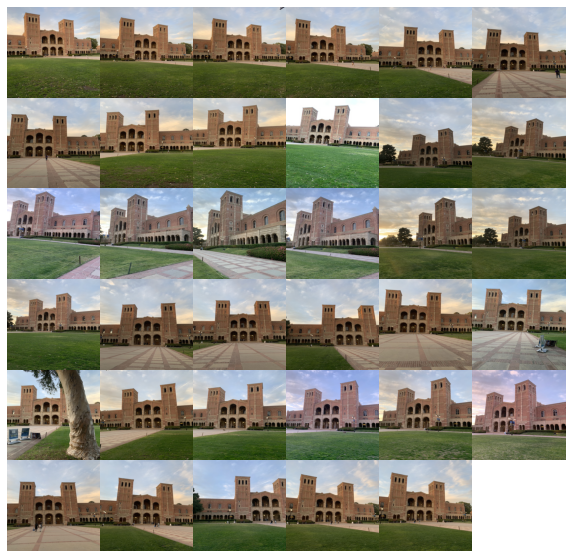

In [4]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    print(img_names)
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    print(img_paths)
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs(image_dir)
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
# for i in range(5):
#   plt.imshow(imgs[i])
#   plt.show()
    
plt.figure(figsize=(10,10))

for i, image in enumerate(imgs):
    plt.subplot(6, 6, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

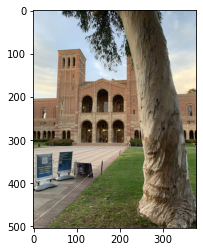

In [37]:
img = imageio.imread('./Royce/IMG_3814.JPG')[:, :, :3]  # (H, W, 3) np.uint8
plt.imshow(img)

In [16]:
import os
len(os.listdir('./Royce'))

35

['IMG_3789.JPG' 'IMG_3790.JPG' 'IMG_3791.JPG' 'IMG_3792.JPG'
 'IMG_3793.JPG' 'IMG_3794.JPG' 'IMG_3795.JPG' 'IMG_3796.JPG'
 'IMG_3797.JPG' 'IMG_3798.JPG' 'IMG_3799.JPG' 'IMG_3800.JPG'
 'IMG_3802.JPG' 'IMG_3803.JPG' 'IMG_3804.JPG' 'IMG_3805.JPG'
 'IMG_3806.JPG' 'IMG_3807.JPG' 'IMG_3808.JPG' 'IMG_3809.JPG'
 'IMG_3810.JPG' 'IMG_3811.JPG' 'IMG_3812.JPG' 'IMG_3813.JPG'
 'IMG_3815.JPG' 'IMG_3816.JPG' 'IMG_3817.JPG' 'IMG_3818.JPG'
 'IMG_3819.JPG' 'IMG_3820.JPG' 'IMG_3821.JPG' 'IMG_3822.JPG'
 'IMG_3823.JPG' 'IMG_3824.JPG']
['Royce_Clean/IMG_3789.JPG', 'Royce_Clean/IMG_3790.JPG', 'Royce_Clean/IMG_3791.JPG', 'Royce_Clean/IMG_3792.JPG', 'Royce_Clean/IMG_3793.JPG', 'Royce_Clean/IMG_3794.JPG', 'Royce_Clean/IMG_3795.JPG', 'Royce_Clean/IMG_3796.JPG', 'Royce_Clean/IMG_3797.JPG', 'Royce_Clean/IMG_3798.JPG', 'Royce_Clean/IMG_3799.JPG', 'Royce_Clean/IMG_3800.JPG', 'Royce_Clean/IMG_3802.JPG', 'Royce_Clean/IMG_3803.JPG', 'Royce_Clean/IMG_3804.JPG', 'Royce_Clean/IMG_3805.JPG', 'Royce_Clean/IMG_3806.JPG', 'Ro

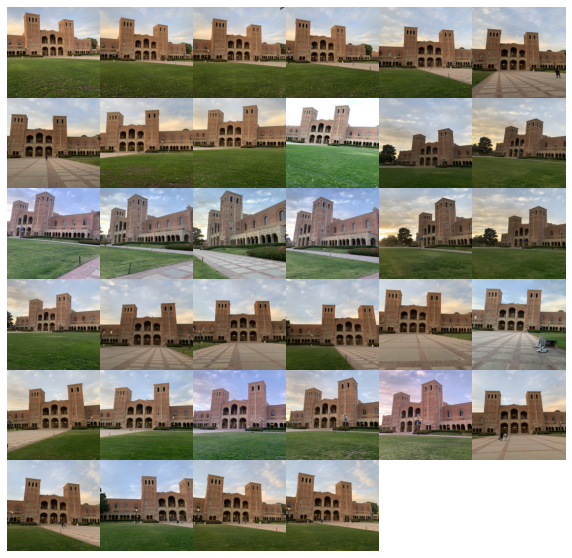

In [26]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    print(img_names)
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    print(img_paths)
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs('Royce_Clean')
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
# for i in range(5):
#   plt.imshow(imgs[i])
#   plt.show()
    
plt.figure(figsize=(10,10))

for i, image in enumerate(imgs):
    plt.subplot(6, 6, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [4]:
from model import *

In [5]:
from train import *

In [ ]:
from model import *
from train import *

N_EPOCH = 1000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = Nerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/ec2-user/.conda/envs/colmap/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch    0 Training PSNR 12.698, estimated fx 377.7 fy 504.2
epoch    1 Training PSNR 14.971, estimated fx 378.7 fy 501.1
epoch    2 Training PSNR 15.012, estimated fx 380.6 fy 500.6
epoch    3 Training PSNR 14.861, estimated fx 385.6 fy 511.6
epoch    4 Training PSNR 15.076, estimated fx 390.3 fy 527.4
epoch    5 Training PSNR 15.090, estimated fx 391.4 fy 530.6
epoch    6 Training PSNR 15.441, estimated fx 400.7 fy 541.4
epoch    7 Training PSNR 15.359, estimated fx 409.1 fy 558.4
epoch    8 Training PSNR 15.639, estimated fx 418.3 fy 577.0
epoch    9 Training PSNR 15.352, estimated fx 428.6 fy 589.9
epoch   10 Training PSNR 16.060, estimated fx 435.8 fy 600.8
epoch   11 Training PSNR 15.839, estimated fx 448.7 fy 602.6
epoch   12 Training PSNR 16.125, estimated fx 454.9 fy 601.6
epoch   13 Training PSNR 16.012, estimated fx 458.8 fy 603.5
epoch   14 Training PSNR 16.298, estimated fx 467.0 fy 603.0
epoch   15 Training PSNR 16.322, estimated fx 471.4 fy 610.2
epoch   16 Training PSNR

epoch  135 Training PSNR 18.187, estimated fx 475.0 fy 539.4
epoch  136 Training PSNR 18.019, estimated fx 474.3 fy 537.6
epoch  137 Training PSNR 18.408, estimated fx 479.8 fy 537.3
epoch  138 Training PSNR 18.438, estimated fx 471.9 fy 543.7
epoch  139 Training PSNR 18.263, estimated fx 473.5 fy 537.6
epoch  140 Training PSNR 18.271, estimated fx 475.3 fy 534.6
epoch  141 Training PSNR 18.444, estimated fx 473.5 fy 535.3
epoch  142 Training PSNR 18.433, estimated fx 473.9 fy 534.8
epoch  143 Training PSNR 18.351, estimated fx 476.5 fy 536.6
epoch  144 Training PSNR 18.440, estimated fx 476.2 fy 539.6
epoch  145 Training PSNR 18.390, estimated fx 472.3 fy 533.7
epoch  146 Training PSNR 18.435, estimated fx 472.8 fy 533.1
epoch  147 Training PSNR 18.331, estimated fx 473.3 fy 535.5
epoch  148 Training PSNR 18.732, estimated fx 474.0 fy 533.9
epoch  149 Training PSNR 18.658, estimated fx 476.6 fy 530.3
epoch  150 Training PSNR 18.445, estimated fx 474.4 fy 532.6
epoch  151 Training PSNR

epoch  270 Training PSNR 19.858, estimated fx 465.2 fy 483.4
epoch  271 Training PSNR 19.727, estimated fx 464.2 fy 480.8
epoch  272 Training PSNR 19.546, estimated fx 464.3 fy 482.7
epoch  273 Training PSNR 19.808, estimated fx 466.3 fy 479.1
epoch  274 Training PSNR 19.741, estimated fx 465.7 fy 479.5
epoch  275 Training PSNR 19.676, estimated fx 466.0 fy 472.5
epoch  276 Training PSNR 19.199, estimated fx 463.5 fy 480.2
epoch  277 Training PSNR 19.559, estimated fx 461.7 fy 478.0
epoch  278 Training PSNR 19.526, estimated fx 461.9 fy 479.7
epoch  279 Training PSNR 19.845, estimated fx 465.3 fy 481.6
epoch  280 Training PSNR 19.610, estimated fx 465.7 fy 474.7
epoch  281 Training PSNR 19.618, estimated fx 464.6 fy 478.1
epoch  282 Training PSNR 19.620, estimated fx 461.9 fy 481.1
epoch  283 Training PSNR 19.636, estimated fx 470.9 fy 479.1
epoch  284 Training PSNR 19.649, estimated fx 466.1 fy 476.2
epoch  285 Training PSNR 19.704, estimated fx 463.4 fy 475.4
epoch  286 Training PSNR

epoch  405 Training PSNR 20.488, estimated fx 448.1 fy 450.0
epoch  406 Training PSNR 20.428, estimated fx 450.1 fy 450.2
epoch  407 Training PSNR 20.305, estimated fx 445.6 fy 444.5
epoch  408 Training PSNR 20.378, estimated fx 446.6 fy 452.2
epoch  409 Training PSNR 20.520, estimated fx 446.3 fy 451.7
epoch  410 Training PSNR 20.259, estimated fx 446.5 fy 451.4
epoch  411 Training PSNR 20.515, estimated fx 444.5 fy 445.8
epoch  412 Training PSNR 20.565, estimated fx 446.0 fy 449.3
epoch  413 Training PSNR 20.421, estimated fx 447.2 fy 449.3
epoch  414 Training PSNR 20.393, estimated fx 447.4 fy 447.3
epoch  415 Training PSNR 20.400, estimated fx 446.1 fy 449.0
epoch  416 Training PSNR 20.248, estimated fx 446.2 fy 450.7
epoch  417 Training PSNR 20.257, estimated fx 446.1 fy 453.6
epoch  418 Training PSNR 20.419, estimated fx 442.6 fy 447.5
epoch  419 Training PSNR 20.616, estimated fx 445.5 fy 449.2
epoch  420 Training PSNR 20.577, estimated fx 444.9 fy 450.0
epoch  421 Training PSNR

epoch  540 Training PSNR 20.851, estimated fx 433.8 fy 436.6
epoch  541 Training PSNR 20.797, estimated fx 435.7 fy 436.4
epoch  542 Training PSNR 20.791, estimated fx 435.8 fy 435.2
epoch  543 Training PSNR 20.819, estimated fx 435.2 fy 434.3
epoch  544 Training PSNR 20.672, estimated fx 434.9 fy 434.7
epoch  545 Training PSNR 20.688, estimated fx 434.0 fy 432.6
epoch  546 Training PSNR 20.716, estimated fx 437.2 fy 431.0
epoch  547 Training PSNR 21.125, estimated fx 433.5 fy 434.1
epoch  548 Training PSNR 20.789, estimated fx 435.9 fy 434.9
epoch  549 Training PSNR 20.963, estimated fx 434.3 fy 432.7
epoch  550 Training PSNR 20.775, estimated fx 434.8 fy 429.6
epoch  551 Training PSNR 21.031, estimated fx 433.6 fy 429.7
epoch  552 Training PSNR 20.917, estimated fx 437.3 fy 434.7
epoch  553 Training PSNR 20.943, estimated fx 435.8 fy 433.1
epoch  554 Training PSNR 20.816, estimated fx 432.7 fy 436.6
epoch  555 Training PSNR 20.754, estimated fx 434.4 fy 433.3
epoch  556 Training PSNR

In [ ]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'normal' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'normal'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

In [ ]:
Image(open(os.path.join('nvs_results', scene_name +  'normal' +'_img.gif'), 'rb').read())

## Try Different Nerf Sizes

In [ ]:
from model import *
from train import *

N_EPOCH = 1000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = BigNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

In [ ]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'big' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'big'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

In [ ]:
Image(open(os.path.join('nvs_results', scene_name +  'big' +'_img.gif'), 'rb').read())

In [4]:
from model import *
from train import *

N_EPOCH = 1000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/ec2-user/.conda/envs/colmap/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch    0 Training PSNR 12.825, estimated fx 379.4 fy 500.0
epoch    1 Training PSNR 15.014, estimated fx 368.8 fy 510.2
epoch    2 Training PSNR 14.788, estimated fx 371.6 fy 510.7
epoch    3 Training PSNR 15.057, estimated fx 369.7 fy 520.0
epoch    4 Training PSNR 14.955, estimated fx 369.4 fy 526.4
epoch    5 Training PSNR 15.214, estimated fx 368.9 fy 529.2
epoch    6 Training PSNR 15.268, estimated fx 372.3 fy 550.0
epoch    7 Training PSNR 15.265, estimated fx 381.6 fy 561.8
epoch    8 Training PSNR 15.582, estimated fx 390.4 fy 580.1
epoch    9 Training PSNR 15.708, estimated fx 408.9 fy 598.3
epoch   10 Training PSNR 15.730, estimated fx 427.9 fy 616.6
epoch   11 Training PSNR 15.839, estimated fx 434.8 fy 635.7
epoch   12 Training PSNR 15.973, estimated fx 436.7 fy 652.0
epoch   13 Training PSNR 15.959, estimated fx 443.3 fy 674.6
epoch   14 Training PSNR 16.175, estimated fx 450.6 fy 683.6
epoch   15 Training PSNR 16.489, estimated fx 452.6 fy 698.2
epoch   16 Training PSNR

epoch  135 Training PSNR 18.587, estimated fx 453.6 fy 630.2
epoch  136 Training PSNR 18.879, estimated fx 452.5 fy 627.3
epoch  137 Training PSNR 18.525, estimated fx 458.4 fy 630.7
epoch  138 Training PSNR 18.721, estimated fx 453.6 fy 630.3
epoch  139 Training PSNR 18.639, estimated fx 454.3 fy 631.2
epoch  140 Training PSNR 18.668, estimated fx 451.5 fy 628.4
epoch  141 Training PSNR 18.713, estimated fx 450.9 fy 622.8
epoch  142 Training PSNR 18.823, estimated fx 451.3 fy 620.9
epoch  143 Training PSNR 18.675, estimated fx 452.3 fy 623.1
epoch  144 Training PSNR 18.532, estimated fx 451.2 fy 621.3
epoch  145 Training PSNR 18.878, estimated fx 454.3 fy 616.9
epoch  146 Training PSNR 18.515, estimated fx 453.3 fy 618.7
epoch  147 Training PSNR 18.556, estimated fx 449.1 fy 610.3
epoch  148 Training PSNR 18.814, estimated fx 448.6 fy 614.8
epoch  149 Training PSNR 18.973, estimated fx 455.2 fy 613.3
epoch  150 Training PSNR 18.795, estimated fx 447.5 fy 616.1
epoch  151 Training PSNR

epoch  270 Training PSNR 19.586, estimated fx 405.4 fy 563.9
epoch  271 Training PSNR 19.652, estimated fx 406.2 fy 553.6
epoch  272 Training PSNR 19.565, estimated fx 404.6 fy 554.2
epoch  273 Training PSNR 19.563, estimated fx 408.9 fy 554.2
epoch  274 Training PSNR 19.304, estimated fx 409.3 fy 551.6
epoch  275 Training PSNR 19.677, estimated fx 406.4 fy 554.7
epoch  276 Training PSNR 19.858, estimated fx 403.6 fy 552.1
epoch  277 Training PSNR 20.027, estimated fx 403.8 fy 554.0
epoch  278 Training PSNR 19.657, estimated fx 403.6 fy 555.8
epoch  279 Training PSNR 19.664, estimated fx 404.1 fy 550.8
epoch  280 Training PSNR 19.763, estimated fx 405.4 fy 552.5
epoch  281 Training PSNR 19.829, estimated fx 406.7 fy 549.3
epoch  282 Training PSNR 19.647, estimated fx 404.2 fy 551.0
epoch  283 Training PSNR 19.823, estimated fx 403.2 fy 552.7
epoch  284 Training PSNR 19.845, estimated fx 405.2 fy 554.5
epoch  285 Training PSNR 19.788, estimated fx 404.1 fy 552.7
epoch  286 Training PSNR

epoch  410 Training PSNR 20.609, estimated fx 388.2 fy 512.2
epoch  411 Training PSNR 20.380, estimated fx 388.4 fy 511.1
epoch  412 Training PSNR 20.302, estimated fx 388.8 fy 512.2
epoch  413 Training PSNR 20.515, estimated fx 388.2 fy 513.9
epoch  414 Training PSNR 20.733, estimated fx 387.7 fy 515.6
epoch  415 Training PSNR 20.484, estimated fx 386.5 fy 512.8
epoch  416 Training PSNR 20.741, estimated fx 387.7 fy 512.9
epoch  417 Training PSNR 20.397, estimated fx 386.0 fy 511.1
epoch  418 Training PSNR 20.388, estimated fx 384.7 fy 511.2
epoch  419 Training PSNR 20.622, estimated fx 388.5 fy 511.1
epoch  420 Training PSNR 20.763, estimated fx 387.2 fy 510.3
epoch  421 Training PSNR 20.513, estimated fx 387.3 fy 513.3
epoch  422 Training PSNR 20.473, estimated fx 386.0 fy 507.3
epoch  423 Training PSNR 20.655, estimated fx 385.9 fy 510.9
epoch  424 Training PSNR 20.488, estimated fx 385.1 fy 512.9
epoch  425 Training PSNR 20.789, estimated fx 384.9 fy 510.1
epoch  426 Training PSNR

epoch  545 Training PSNR 21.184, estimated fx 373.2 fy 489.7
epoch  546 Training PSNR 20.807, estimated fx 374.2 fy 489.6
epoch  547 Training PSNR 20.854, estimated fx 375.7 fy 484.7
epoch  548 Training PSNR 20.738, estimated fx 373.8 fy 485.3
epoch  549 Training PSNR 20.821, estimated fx 375.3 fy 486.2
epoch  550 Training PSNR 21.178, estimated fx 375.4 fy 486.5
epoch  551 Training PSNR 21.040, estimated fx 375.1 fy 487.0
epoch  552 Training PSNR 21.046, estimated fx 376.4 fy 485.7
epoch  553 Training PSNR 21.256, estimated fx 375.5 fy 484.1
epoch  554 Training PSNR 21.053, estimated fx 374.9 fy 484.2
epoch  555 Training PSNR 21.033, estimated fx 376.5 fy 485.7
epoch  556 Training PSNR 20.988, estimated fx 374.2 fy 485.3
epoch  557 Training PSNR 20.750, estimated fx 374.5 fy 485.3
epoch  558 Training PSNR 20.715, estimated fx 376.0 fy 483.8
epoch  559 Training PSNR 20.842, estimated fx 372.7 fy 483.7
epoch  560 Training PSNR 21.187, estimated fx 373.1 fy 484.4
epoch  561 Training PSNR

epoch  680 Training PSNR 21.062, estimated fx 363.7 fy 470.9
epoch  681 Training PSNR 21.226, estimated fx 364.7 fy 473.5
epoch  682 Training PSNR 21.223, estimated fx 364.5 fy 473.5
epoch  683 Training PSNR 21.307, estimated fx 365.2 fy 474.0
epoch  684 Training PSNR 21.471, estimated fx 362.6 fy 472.8
epoch  685 Training PSNR 21.362, estimated fx 367.2 fy 474.5
epoch  686 Training PSNR 20.934, estimated fx 364.3 fy 474.4
epoch  687 Training PSNR 21.342, estimated fx 363.2 fy 470.9
epoch  688 Training PSNR 21.359, estimated fx 364.8 fy 473.4
epoch  689 Training PSNR 21.247, estimated fx 364.1 fy 473.0
epoch  690 Training PSNR 21.362, estimated fx 363.8 fy 471.9
epoch  691 Training PSNR 21.280, estimated fx 366.4 fy 473.3
epoch  692 Training PSNR 21.240, estimated fx 364.1 fy 470.6
epoch  693 Training PSNR 21.373, estimated fx 365.2 fy 470.8
epoch  694 Training PSNR 21.474, estimated fx 365.0 fy 469.7
epoch  695 Training PSNR 21.288, estimated fx 364.9 fy 469.1
epoch  696 Training PSNR

epoch  815 Training PSNR 21.608, estimated fx 360.7 fy 462.5
epoch  816 Training PSNR 21.521, estimated fx 360.4 fy 463.1
epoch  817 Training PSNR 21.446, estimated fx 359.3 fy 462.6
epoch  818 Training PSNR 21.476, estimated fx 359.8 fy 463.1
epoch  819 Training PSNR 21.549, estimated fx 360.5 fy 463.4
epoch  820 Training PSNR 21.479, estimated fx 360.9 fy 464.3
epoch  821 Training PSNR 21.478, estimated fx 359.7 fy 462.5
epoch  822 Training PSNR 21.283, estimated fx 360.6 fy 461.5
epoch  823 Training PSNR 21.544, estimated fx 358.6 fy 463.0
epoch  824 Training PSNR 21.378, estimated fx 359.4 fy 463.3
epoch  825 Training PSNR 21.703, estimated fx 361.5 fy 462.3
epoch  826 Training PSNR 21.550, estimated fx 359.1 fy 461.3
epoch  827 Training PSNR 21.300, estimated fx 360.5 fy 461.7
epoch  828 Training PSNR 21.415, estimated fx 361.0 fy 462.5
epoch  829 Training PSNR 21.769, estimated fx 359.1 fy 462.4
epoch  830 Training PSNR 21.510, estimated fx 361.1 fy 463.0
epoch  831 Training PSNR

epoch  950 Training PSNR 21.657, estimated fx 357.1 fy 457.9
epoch  951 Training PSNR 21.612, estimated fx 356.0 fy 459.6
epoch  952 Training PSNR 21.707, estimated fx 356.8 fy 459.4
epoch  953 Training PSNR 21.846, estimated fx 357.0 fy 459.7
epoch  954 Training PSNR 21.689, estimated fx 357.0 fy 458.4
epoch  955 Training PSNR 21.909, estimated fx 358.2 fy 459.4
epoch  956 Training PSNR 21.875, estimated fx 357.7 fy 458.3
epoch  957 Training PSNR 21.747, estimated fx 357.6 fy 458.5
epoch  958 Training PSNR 21.703, estimated fx 357.1 fy 456.5
epoch  959 Training PSNR 21.554, estimated fx 356.7 fy 458.3
epoch  960 Training PSNR 21.898, estimated fx 357.4 fy 457.8
epoch  961 Training PSNR 21.975, estimated fx 356.7 fy 457.8
epoch  962 Training PSNR 21.727, estimated fx 357.1 fy 457.8
epoch  963 Training PSNR 21.840, estimated fx 358.1 fy 457.8
epoch  964 Training PSNR 21.779, estimated fx 357.2 fy 457.3
epoch  965 Training PSNR 21.790, estimated fx 358.2 fy 458.5
epoch  966 Training PSNR

In [5]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'normal' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'normal'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 504 x 378 for 1000 epochs
Rendering novel views in 126 x 94


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...
GIF images saved.


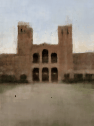

In [6]:
Image(open(os.path.join('nvs_results', scene_name +  'normal' +'_img.gif'), 'rb').read())

## Try Clean Dataset

In [ ]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    print(img_names)
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    print(img_paths)
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs('Royce_Clean')
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
# for i in range(5):
#   plt.imshow(imgs[i])
#   plt.show()
    
plt.figure(figsize=(10,10))

for i, image in enumerate(imgs):
    plt.subplot(6, 6, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
from model import *
from train import *

N_EPOCH = 3000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a NeRF model. Hidden dimension set to 128
nerf_model = Nerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, image_data)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

In [ ]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=25, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=1.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + 'clean' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name +'clean'+ '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

In [ ]:
Image(open(os.path.join('nvs_results', scene_name +  'clean' +'_img.gif'), 'rb').read())